In [1]:
import numpy as np
import pandas as pd
from import_data import *
import torch
import torch.optim as optim
import torch.nn as nn
from network import DNN, DNN_v1, DNN_cat
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from utils import EarlyStopping, KFOLD_GCN
# from matplotlib import pyplot as plt
# from config import args
from collections import Counter


# 
# Data Load

In [2]:
if torch.cuda.is_available():
    print("Let's go CUDA!!!!!")
    cuda = torch.device('cuda')
else:
    print("No CUDA,,,")
    cuda = torch.device('cpu')

np.random.seed(777)
kfold = 5
# y_value = args.y


data1, data2, data3, data4 = DATA_PREPROCESS_SH_v2()

def xysplit(data):
    xdata = data[data.columns.difference(['L3008_cholesterol', 'L3061_tg', 'L3062_hdl', 'L3068_ldl'])]
    ydata = data[['L3008_cholesterol', 'L3061_tg', 'L3062_hdl', 'L3068_ldl']]
    
    return xdata, ydata




/home/kicarus/anaconda3/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


No CUDA,,,


/home/kicarus/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (5,6,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
xdata, ydata = xysplit(data2)

In [4]:
ckpath = 'ckeckpoint_remove.pt'

# 
# Removing

In [5]:
xcols = xdata.columns
ycols = ydata.columns

xnorm = NORMALIZATION(xdata, 'standard')
ylabel = CATEGORIZATION_v2(np.array(ydata))

In [6]:

def _ychoice(y):
    xcols = xdata.columns
    ycols = ydata.columns
    npy = np.array(ydata)

    xnorm = NORMALIZATION(xdata, 'standard')
    ylabel = CATEGORIZATION_v2(npy)
    
    this = np.transpose(np.concatenate((np.transpose(xdata), [npy[:, y]]), axis=0))
    idx = REMOVE_AMBIGUOUS(this, y)
    
    this = np.transpose(np.concatenate((np.transpose(xdata), [ylabel[:, y]]), axis=0))
    train = this[idx]
    removed = np.delete(this, idx, axis=0)
    np.random.shuffle(train)
    
    return train, removed


def _ychoice_tmp(y):
    xcols = xdata.columns
    ycols = ydata.columns
    npy = np.array(ydata)

    xnorm = NORMALIZATION(xdata, 'standard')
    ylabel = CATEGORIZATION_v2(npy)
    
    this = np.transpose(np.concatenate((np.transpose(xdata), [npy[:, y]]), axis=0))
    idx = REMOVE_AMBIGUOUS(this, y)
    
    this = np.transpose(np.concatenate((np.transpose(xdata), [ylabel[:, y]]), axis=0))
    train = this
    
    return train



def _TData_v2(train):
    train_dataset = TensorDataset(torch.Tensor(train[:, :-1]).to(cuda),
                                  torch.LongTensor(train[:, -1]).to(cuda))

    return train_dataset



def Parameters(net):
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.MSELoss(reduction='mean')
    # optimizer = optim.SGD(net.parameters(), lr=0.000001)
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    return criterion, optimizer

def Parameters_cat(net):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    return criterion, optimizer



# 
# Process

In [7]:
def Learning_all(train_loader, val_loader, nodes, num, patience=10, num_classes=None):
    """
        train_loader: 학습시킬 데이터셋 (DataLoader 형식)
        val_loader: 평가할 데이터셋 (DataLoader 형식)
        num: Epochs

    """
    net = DNN_cat(xdata.shape[1], num_classes, nodes)
    criterion, optimizer = Parameters_cat(net)
    net.to(cuda)

    """Early Stopping Template"""
    for epoch in range(num):
        torch.cuda.empty_cache()
        if epoch == 0:
            early_stopping = EarlyStopping(patience=patience, path=ckpath, verbose=False)
        else:
            early_stopping = EarlyStopping(patience=patience, best_score=best_score, counter=counter, path=ckpath, verbose=False)

        # Training
        net.train()
        running_loss = 0.
        lcnt = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.to(cuda)
            labels = labels.to(cuda)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            lcnt += len(labels)

        # Validation
        net.eval()
        net.to(cuda)

        val_loss = 0
        vcnt = 0
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs = inputs.to(cuda)
            labels = labels.to(cuda)
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)

            val_loss += loss.item()
            vcnt += len(labels)

        # Template
        best_score, counter, finish = early_stopping(val_loss / vcnt, net)
        # if epoch % 50 == 0:
        #     print('Epoch Now: %d' % epoch)

        if finish:
            break

    net1 = DNN_cat(xdata.shape[1], num_classes, nodes)
    net1.load_state_dict(torch.load(ckpath))
    net1.eval()

    # output save
    val_loss = 0
    correct = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    precision_c = list(0. for i in range(num_classes))
    precision_t = list(0. for i in range(num_classes))
    label_all = []
    output_all = []
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs = inputs.to(cuda)
            labels = labels.to(cuda)

            outputs = net1(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            val_loss += loss.item()

            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

            for i in range(len(predicted)):
                output = predicted[i].item()
                precision_c[output] += c[i].item()
                precision_t[output] += 1
            
            label_all.append(labels)
            output_all.append(outputs)
            
        print('Best Epoch: %5d / Last Validation Loss: %5f / Accuracy: %.3f'
              % (epoch - patience, val_loss / vcnt, 100 * correct / vcnt))

        for cls in range(num_classes):
            if class_total[cls] == 0:
                print('To small dataset for %s' % cls)
            else:
                print('Recall of %5s : %2d %%' % (
                    cls, 100 * class_correct[cls] / class_total[cls]))

        for cls in range(num_classes):
            if precision_t[cls] == 0:
                print('No prediction for %s' % cls)
            else:
                print('Precision of %5s : %2d %%' % (
                    cls, 100 * precision_c[cls] / precision_t[cls]))

    return correct / vcnt, label_all, output_all


def RUN_all(batch_size, kfold, max_epoch, y_value, node_list, patience):
    # Train / Test split
    print('이전 데이터 수: %d' %(len(xdata)))
    data, removed = _ychoice(y_value)
    
    print('삭제 후 데이터 수: %d' %(len(data)))
    num_classes = len(set(data[:, -1]))
    tmp = KFOLD_GCN(data, KFOLD=10)
    train = np.vstack(tmp[:-1])
    test = tmp[-1]


    print('\n\n\n가즈아~!~!~!~!~!')
    print('y_value: %2d' % y_value)

    acc_box = []
    for nodes in node_list:

        acc = 0
        print('Nodes: %2d' % nodes)

        kfold_all = KFOLD_GCN(train, kfold)
        for k in range(kfold):
            validation = kfold_all[k]
            training = []
            for exp in range(kfold):
                if exp != k:
                    training.append(kfold_all[exp])
            training = np.vstack(training)

            train_loader = DataLoader(_TData_v2(training), batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(_TData_v2(validation), batch_size=batch_size, shuffle=False)
            acc_all, label_all, output_all = Learning_all(train_loader, val_loader, nodes, max_epoch, patience, num_classes)
            acc += acc_all

        print('Validation Accuracy: %f' % (acc / kfold))
        acc_box.append(acc / kfold)
        
        
    best_node = node_list[acc_box.index(max(acc_box))]
    train_loader = DataLoader(_TData_v2(train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(_TData_v2(test), batch_size=batch_size, shuffle=False)
    test_removed = DataLoader(_TData_v2(removed), batch_size=batch_size, shuffle=False)
    
    print('')
    print('This is best result with non-ambiguous data')
    print('')
    acc_all, label_all, output_all = Learning_all(train_loader, test_loader, best_node, max_epoch, patience, num_classes)
    nonamb = np.hstack([i.numpy() for i in label_all]), np.vstack([i.numpy() for i in output_all])
    
    print('')
    print('This is ambiguous data')
    print('')
    acc_all, label_all, output_all = Learning_all(train_loader, test_removed, best_node, max_epoch, patience, num_classes)
    amb = np.hstack([i.numpy() for i in label_all]), np.vstack([i.numpy() for i in output_all])

    return nonamb, amb

# 
# Parameter

In [8]:
batch_size = 128
kfold = 5
max_epoch = 1000
n_list = [6, 9, 12, 15, 18, 21, 24]

In [32]:
a, b = RUN_all(batch_size, kfold, max_epoch, y_value=-4, node_list=n_list, patience=100)

이전 데이터 수: 5382
삭제 후 데이터 수: 2460



가즈아~!~!~!~!~!
y_value: -4
Nodes:  6
Early Stopping Validated
Best Epoch:   129 / Last Validation Loss: 0.002900 / Accuracy: 88.009
Recall of     0 : 90 %
Recall of     1 : 78 %
Precision of     0 : 93 %
Precision of     1 : 71 %
Early Stopping Validated
Best Epoch:   219 / Last Validation Loss: 0.002599 / Accuracy: 90.498
Recall of     0 : 92 %
Recall of     1 : 83 %
Precision of     0 : 94 %
Precision of     1 : 77 %
Early Stopping Validated
Best Epoch:   197 / Last Validation Loss: 0.002639 / Accuracy: 90.045
Recall of     0 : 92 %
Recall of     1 : 81 %
Precision of     0 : 94 %
Precision of     1 : 76 %
Early Stopping Validated
Best Epoch:   209 / Last Validation Loss: 0.003239 / Accuracy: 88.939
Recall of     0 : 92 %
Recall of     1 : 75 %
Precision of     0 : 92 %
Precision of     1 : 76 %
Early Stopping Validated
Best Epoch:   137 / Last Validation Loss: 0.002705 / Accuracy: 90.766
Recall of     0 : 94 %
Recall of     1 : 77 %
Precision of    

In [31]:
a1, b1 = RUN_all(batch_size, kfold, max_epoch, y_value=-3, node_list=n_list, patience=100)

이전 데이터 수: 5382
삭제 후 데이터 수: 4455



가즈아~!~!~!~!~!
y_value: -3
Nodes:  6
Early Stopping Validated
Best Epoch:    46 / Last Validation Loss: 0.002218 / Accuracy: 95.750
Recall of     0 : 98 %
Recall of     1 : 43 %
Precision of     0 : 97 %
Precision of     1 : 55 %
Early Stopping Validated
Best Epoch:   245 / Last Validation Loss: 0.002344 / Accuracy: 96.259
Recall of     0 : 98 %
Recall of     1 : 44 %
Precision of     0 : 97 %
Precision of     1 : 65 %
Early Stopping Validated
Best Epoch:   112 / Last Validation Loss: 0.003054 / Accuracy: 95.262
Recall of     0 : 100 %
Recall of     1 :  0 %
Precision of     0 : 95 %
No prediction for 1
Early Stopping Validated
Best Epoch:   143 / Last Validation Loss: 0.002031 / Accuracy: 96.010
Recall of     0 : 98 %
Recall of     1 : 39 %
Precision of     0 : 97 %
Precision of     1 : 62 %
Early Stopping Validated
Best Epoch:   105 / Last Validation Loss: 0.002785 / Accuracy: 95.262
Recall of     0 : 100 %
Recall of     1 :  0 %
Precision of     0 :

In [33]:
a2, b2 = RUN_all(batch_size, kfold, max_epoch, y_value=-2, node_list=n_list, patience=100)

이전 데이터 수: 5382
삭제 후 데이터 수: 1167



가즈아~!~!~!~!~!
y_value: -2
Nodes:  6
Early Stopping Validated
Best Epoch:   419 / Last Validation Loss: 0.000278 / Accuracy: 99.043
Recall of     0 : 97 %
Recall of     1 : 99 %
Precision of     0 : 97 %
Precision of     1 : 99 %
Early Stopping Validated
Best Epoch:   338 / Last Validation Loss: 0.000440 / Accuracy: 98.086
Recall of     0 : 93 %
Recall of     1 : 99 %
Precision of     0 : 97 %
Precision of     1 : 98 %
Early Stopping Validated
Best Epoch:   245 / Last Validation Loss: 0.000428 / Accuracy: 98.565
Recall of     0 : 97 %
Recall of     1 : 98 %
Precision of     0 : 95 %
Precision of     1 : 99 %
Early Stopping Validated
Best Epoch:   147 / Last Validation Loss: 0.000828 / Accuracy: 96.209
Recall of     0 : 93 %
Recall of     1 : 96 %
Precision of     0 : 90 %
Precision of     1 : 98 %
Early Stopping Validated
Best Epoch:   242 / Last Validation Loss: 0.000522 / Accuracy: 97.630
Recall of     0 : 93 %
Recall of     1 : 98 %
Precision of    

In [34]:
a3, b3 = RUN_all(batch_size, kfold, max_epoch, y_value=-1, node_list=n_list, patience=100)

이전 데이터 수: 5382
삭제 후 데이터 수: 2390



가즈아~!~!~!~!~!
y_value: -1
Nodes:  6
Early Stopping Validated
Best Epoch:   155 / Last Validation Loss: 0.001933 / Accuracy: 92.075
Recall of     0 : 93 %
Recall of     1 : 85 %
Precision of     0 : 96 %
Precision of     1 : 75 %
Early Stopping Validated
Best Epoch:   129 / Last Validation Loss: 0.003727 / Accuracy: 86.713
Recall of     0 : 89 %
Recall of     1 : 72 %
Precision of     0 : 93 %
Precision of     1 : 62 %
Early Stopping Validated
Best Epoch:   170 / Last Validation Loss: 0.002412 / Accuracy: 90.930
Recall of     0 : 94 %
Recall of     1 : 76 %
Precision of     0 : 94 %
Precision of     1 : 75 %
Early Stopping Validated
Best Epoch:   175 / Last Validation Loss: 0.002924 / Accuracy: 88.399
Recall of     0 : 90 %
Recall of     1 : 80 %
Precision of     0 : 95 %
Precision of     1 : 65 %
Early Stopping Validated
Best Epoch:   111 / Last Validation Loss: 0.002927 / Accuracy: 89.327
Recall of     0 : 92 %
Recall of     1 : 75 %
Precision of    

In [64]:
from sklearn.metrics import roc_auc_score, f1_score
# from scipy.special import softmax

print(roc_auc_score(a[0], np.array([np.argmax(i) for i in a[1]])))
print(roc_auc_score(a1[0], np.array([np.argmax(i) for i in a1[1]])))
print(roc_auc_score(a2[0], np.array([np.argmax(i) for i in a2[1]])))
print(roc_auc_score(a3[0], np.array([np.argmax(i) for i in a3[1]])))
print(roc_auc_score(b[0], np.array([np.argmax(i) for i in b[1]])))
print(roc_auc_score(b1[0], np.array([np.argmax(i) for i in b1[1]])))
print(roc_auc_score(b2[0], np.array([np.argmax(i) for i in b2[1]])))
print(roc_auc_score(b3[0], np.array([np.argmax(i) for i in b3[1]])))
print('')
print(f1_score(a[0], np.array([np.argmax(i) for i in a[1]])))
print(f1_score(a1[0], np.array([np.argmax(i) for i in a1[1]])))
print(f1_score(a2[0], np.array([np.argmax(i) for i in a2[1]])))
print(f1_score(a3[0], np.array([np.argmax(i) for i in a3[1]])))
print(f1_score(b[0], np.array([np.argmax(i) for i in b[1]])))
print(f1_score(b1[0], np.array([np.argmax(i) for i in b1[1]])))
print(f1_score(b2[0], np.array([np.argmax(i) for i in b2[1]])))
print(f1_score(b3[0], np.array([np.argmax(i) for i in b3[1]])))

0.8052631578947368
0.6293048128342246
0.9519739519739521
0.8017094017094017
0.6516660216037438
0.5087358452750776
0.7431556366338974
0.5882078293102395

0.709090909090909
0.3529411764705882
0.978021978021978
0.7073170731707318
0.7127103888566453
0.10852713178294575
0.7587748714509277
0.3977077363896848


In [60]:
import pickle

filelist = [a, a1, a2, a3]
filename = ['TCH', 'TG', 'HDL', 'LDL']

for i in range(4):
    name = filename[i] + '_remove.pkl'
    with open(name, 'wb') as f:
        pickle.dump(filelist[i], f)
        

In [63]:
import pickle

filelist = [b, b1, b2, b3]
filename = ['TCH', 'TG', 'HDL', 'LDL']

for i in range(4):
    name = filename[i] + '_remove_nonambig.pkl'
    with open(name, 'wb') as f:
        pickle.dump(filelist[i], f)
        

In [56]:
# roc curve and auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

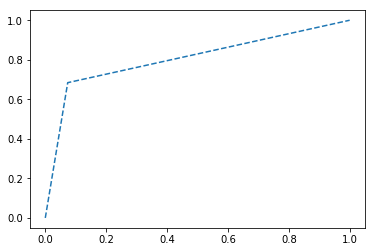

In [58]:
x1, x2, _ = roc_curve(a[0], np.array([np.argmax(i) for i in a[1]]))
plt.plot(x1, x2, linestyle='--', label='')

# 
# 여기부터 Logistic

In [9]:
import statsmodels.api as sm

In [10]:
xcols

Index(['AGE', 'BMI', 'FATTY_DEG', 'HPC00001_height', 'HPC00002_weight',
       'HPC00003_fat_ratio', 'HPC00004_sbp', 'HPC00005_dbp', 'HPC00006_pulse',
       'HPC00007_wc', 'HPCL7606_tsh', 'HPCL7624_ft4', 'L3005_glucose',
       'L3008_cholesterol_shifted', 'L3014_ast', 'L3015_alt',
       'L3061_tg_shifted', 'L3062_hdl_shifted', 'L3068_ldl_shifted',
       'PHx_DL_MED', 'SEX_TP_CD', 'SL_BdTH', 'WtH', 'drinking', 'exercise',
       'interval', 'smoking'],
      dtype='object')

In [46]:
y_value = -1

train, removed = _ychoice(y_value)
total = np.vstack((train, removed))

usedata = total

putdata = NORMALIZATION(train[:, :-1], 'standard')
# putdata = train[:, :-1]

x1 = pd.DataFrame(columns=xcols, data=putdata)
y1 = pd.DataFrame({'label': train[:, -1]})

inspect = [
    'AGE', 'BMI', 'FATTY_DEG', 'HPC00001_height', 'HPC00002_weight', 'HPC00003_fat_ratio', 'HPC00004_sbp', 
    'HPC00005_dbp', 'HPC00006_pulse', 'HPC00007_wc', 'L3005_glucose',
    'L3008_cholesterol_shifted', 'L3014_ast', 'L3015_alt', 'L3061_tg_shifted', 'L3062_hdl_shifted', 
    'L3068_ldl_shifted', 'SEX_TP_CD', 'SL_BdTH', 'WtH', 'drinking', 'exercise', 'interval', 'smoking']

logit = sm.Logit(y1, x1[inspect])
result = logit.fit()
tmp = result.summary()
a = tmp.as_text()
print(a)

Optimization terminated successfully.
         Current function value: 0.574271
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 2390
Model:                          Logit   Df Residuals:                     2366
Method:                           MLE   Df Model:                           23
Date:                Fri, 26 Feb 2021   Pseudo R-squ.:                 -0.1902
Time:                        13:41:27   Log-Likelihood:                -1372.5
converged:                       True   LL-Null:                       -1153.2
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
AGE                          -0.1497      0.065     -2.317      0.020      -0.

In [70]:
logit = sm.Logit(y1, x1[inspect])
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.457323
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 2390
Model:                          Logit   Df Residuals:                     2377
Method:                           MLE   Df Model:                           12
Date:                Wed, 24 Feb 2021   Pseudo R-squ.:                 0.05218
Time:                        15:11:32   Log-Likelihood:                -1093.0
converged:                       True   LL-Null:                       -1153.2
Covariance Type:            nonrobust   LLR p-value:                 5.262e-20
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
AGE                   -0.0241      0.005     -4.609      0.000      -0.034      -0.014
BMI                   -0.1203      0.051     -2.365      0.018      -0.220      -0.021
FATTY_DEG              0.0084      0.092      0.091      0.927      -0.173       0.189
HPC00001_height       -0.0169      0.005     -3.519      0.000      -0.026      -0.007
HPC00002_weight        0.0364      0.014      2.626      0.009       0.009       0.064
HPC00003_fat_ratio     0.0455      0.014      3.291      0.001       0.018       0.073
HPC00004_sbp          -0.0174      0.007     -2.639      0.008      -0.030      -0.004
HPC00005_dbp           0.0277      0.010      2.851      0.004       0.009       0.047
HPC00006_pulse         0.0217      0.005      4.678      0.000       0.013       0.031
drinking              -0.0437      0.066     -0.665      0.506      -0.173       0.085
smoking               -0.1542      0.098     -1.567      0.117      -0.347       0.039
exercise              -0.0190      0.018     -1.037      0.300      -0.055       0.017
HPCL7624_ft4           0.6237      0.339      1.841      0.066      -0.040       1.288
======================================================================================
"""

In [38]:
type(tmp)

statsmodels.iolib.summary.Summary

In [39]:
type(a)

str

                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 2390
Model:                          Logit   Df Residuals:                     2366
Method:                           MLE   Df Model:                           23
Date:                Fri, 26 Feb 2021   Pseudo R-squ.:                 -0.1902
Time:                        13:33:37   Log-Likelihood:                -1372.5
converged:                       True   LL-Null:                       -1153.2
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
AGE                          -0.1497      0.065     -2.317      0.020      -0.276      -0.023
BMI                           0.6212      0.694      0.895      0.371      -0.738     

In [51]:
y1

,label
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2455,0.0
2456,0.0
2457,0.0
2458,0.0
